#Ejercicio 3 – Clasificación de imágenes

## Instalación de librerías

In [6]:
pip install tensorflow

## Importar las bibliotecas

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

## Función para mostrar algunas imágenes del dataset

In [8]:
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[np.argmax(labels[i])])
    plt.show()


## Cargar el dataset CIFAR-10

In [9]:
cifar_10 = datasets.fetch_openml('CIFAR_10_small')
X, y = cifar_10['data'].to_numpy(), cifar_10['target'].to_numpy()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## **Tarea 3a**: Realiza una descripción del dataset.

### Preprocesamiento de datos

Normalizamos los valores de las imágenes.

In [11]:
X = X.reshape(-1, 32, 32, 3) / 255.0
y = y.astype(int)
y = to_categorical(y, num_classes=10)

### Dividir el dataset en conjuntos de entrenamiento y prueba

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reducir el tamaño del dataset para un entrenamiento más rápido en SVM
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.1, stratify=y_train.argmax(axis=1), random_state=42)

### Visualización de las imagenes del dataset


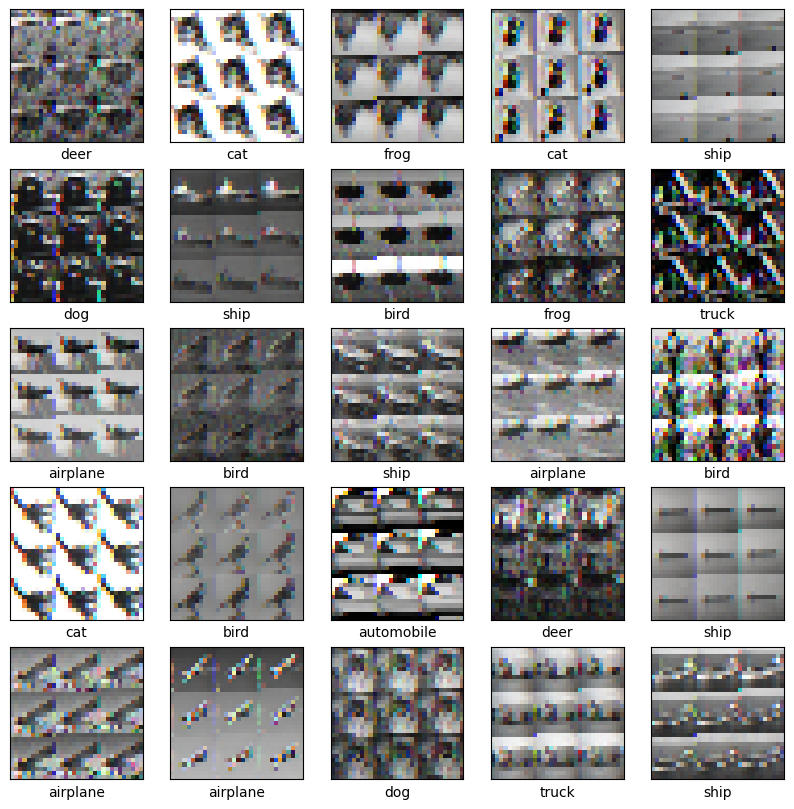

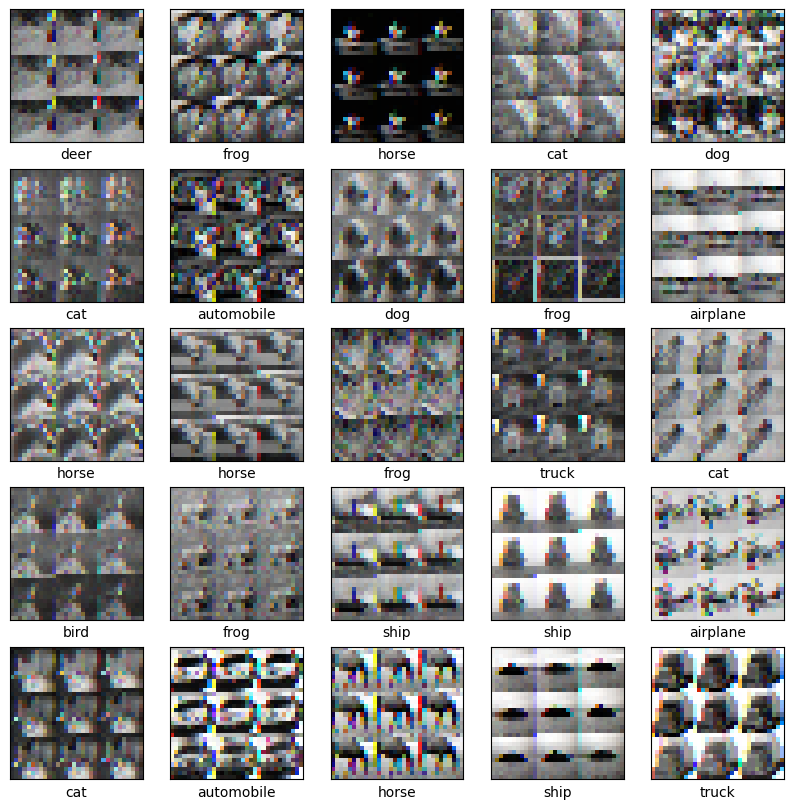

In [13]:
plot_images(X_train, y_train, class_names)

plot_images(X_train_small, y_train_small, class_names)

## Tarea 3b: Entrega y evalúa al menos 3 algoritmos de clasificación

Los algoritmos elegidos son:

* KNN
* SVM con PCA
* Redes Neuronales Convolucionales (CNN)

KNN Classification Report
              precision    recall  f1-score   support

           0       0.28      0.57      0.38       401
           1       0.60      0.18      0.28       410
           2       0.18      0.40      0.25       409
           3       0.26      0.21      0.23       378
           4       0.20      0.37      0.26       369
           5       0.40      0.18      0.24       374
           6       0.42      0.25      0.32       460
           7       0.64      0.17      0.27       376
           8       0.44      0.59      0.50       411
           9       0.55      0.09      0.15       412

    accuracy                           0.30      4000
   macro avg       0.40      0.30      0.29      4000
weighted avg       0.40      0.30      0.29      4000

SVM Classification Report
              precision    recall  f1-score   support

           0       0.37      0.50      0.43       401
           1       0.35      0.37      0.36       410
           2       0.19   

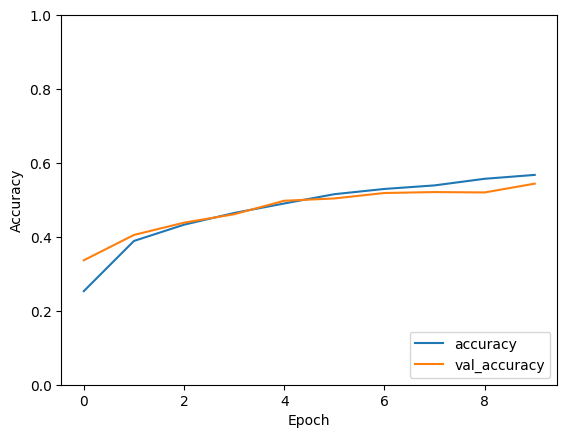

125/125 [==============================] - 1s 6ms/step


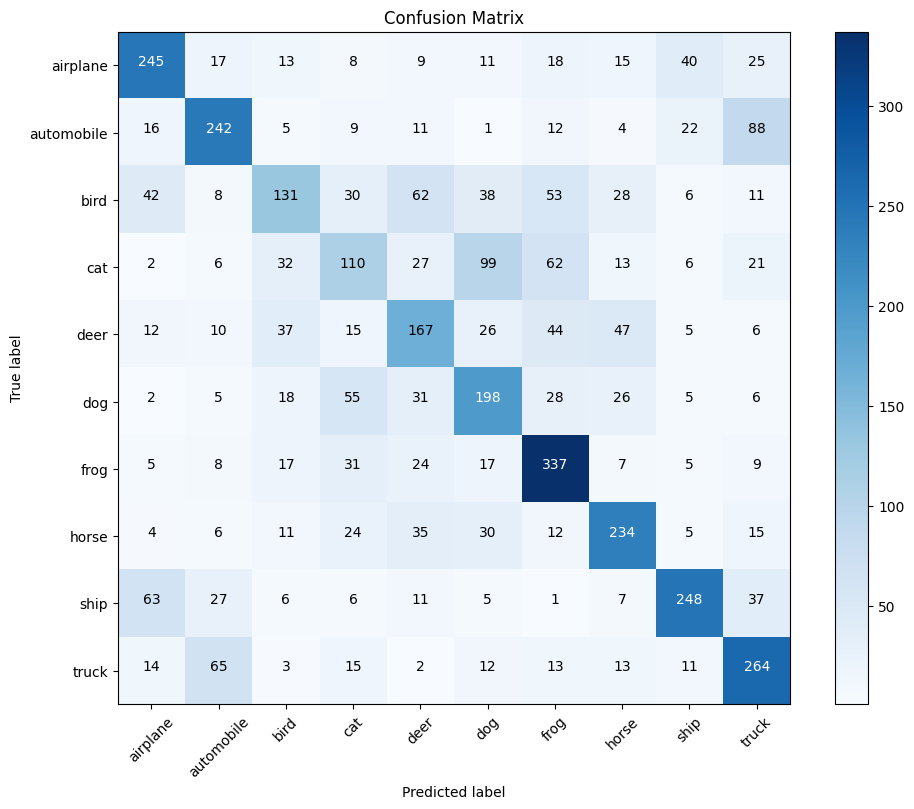

In [14]:
# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
knn.fit(X_train.reshape(len(X_train), -1), y_train.argmax(axis=1))
y_pred_knn = knn.predict(X_test.reshape(len(X_test), -1))
print("KNN Classification Report")
print(classification_report(y_test.argmax(axis=1), y_pred_knn))

# Support Vector Machine (SVM) con PCA
pca = PCA(n_components=100)
X_train_small_flat = X_train_small.reshape(len(X_train_small), -1)
X_test_flat = X_test.reshape(len(X_test), -1)
svm = make_pipeline(pca, SVC(kernel='linear'))

# Entrenar el modelo SVM con el conjunto de datos reducido
svm.fit(X_train_small_flat, y_train_small.argmax(axis=1))

# Evaluar el modelo SVM en el conjunto de prueba completo
y_pred_svm = svm.predict(X_test_flat)
print("SVM Classification Report")
print(classification_report(y_test.argmax(axis=1), y_pred_svm))

# Redes Neuronales Convolucionales (CNN)
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                    validation_data=(X_test, y_test))

# Evaluamos el modelo CNN
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Graficamos las curvas de aprendizaje
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Graficamos la matriz de confusión para CNN
y_pred_cnn = model.predict(X_test)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1))

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()